# Analysis and Inference of experiment `33PD`
This notebook plots the data from the experiment `33PD` and the agent-based model. The parameters of this agent-based models were inferred using particle swarm algorithm and the `33PD` data. 

### Import all the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Load the experimental data as a dataframe

In [2]:
df = pd.read_csv("../data/experiments/data_exp33PD.csv", header=0).drop(0).drop("Unnamed: 0", axis=1)
mask_time = df.columns.str.contains(".1")
df.head()

,02_DMSO alltime,02_DMSO alltime.1,03_10um alltime,03_10um alltime.1,04_500um alltime,04_500um alltime.1,05_Control 30 min removed,05_Control 30 min removed.1,06_DMSO30 min removed,06_DMSO30 min removed.1,...,09_Control 2h removal,09_Control 2h removal.1,10_DMSO 2h removal,10_DMSO 2h removal.1,11_10um 2h removal,11_10um 2h removal.1,12_500um 2h removal,12_500um 2h removal.1,01_Control,01_Control.1
1,290,0.007156387770833333,166,0.013694347770833334,171,0.019995505104166665,96,0.0265987504375,123,0.033842835770833336,...,104,0.05631885710416667,168,0.06357002777083333,214,0.0710376944375,240,0.0798401344375,213,0.0005312624375
2,337,0.5161709771041667,220,0.5314216677708333,226,0.5471891957708334,116,0.5639332704375,136,0.5802217131041667,...,134,0.6263888464375,168,0.6429660117708333,185,0.6586780597708334,228,0.6727880011041667,259,0.5004774757708333
3,356,1.0109366064375,224,1.0207481237708333,233,1.0305483904375,120,1.0398824357708334,125,1.0495986037708334,...,142,1.0795643077705555,169,1.0887523797708334,173,1.0983921584375,233,1.1075009931041666,261,1.0004406037708333
4,329,1.5103078704375,228,1.5199430651041668,227,1.5289386304375,146,1.5378297531041667,130,1.5476564757708333,...,159,1.5764233744375,182,1.5864811077708334,181,1.5975503824375,219,1.6070005397708333,299,1.5004413904375
5,347,2.0104518304375,230,2.020966547770833,236,2.030530073104167,162,2.0402759984375,138,2.0498074384375,...,157,2.0787539584375,202,2.0885838411041666,186,2.0992692277708334,227,2.1098003317708334,337,2.0004257291041667


## Plot the fold change over time
We want to compare the _DMSO_ control and the 500 uM _TMZ_ treamtments. To calculate the fold change in cell numbers we normalize the timeseries by dividing with the 11th observation.

Text(0, 0.5, 'fold change in cell count')

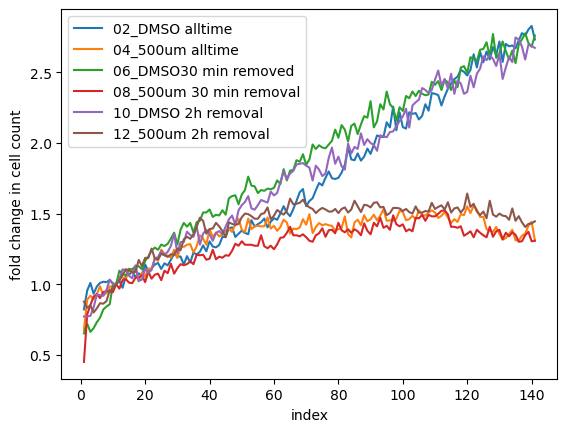

In [3]:
df.loc[:, ~mask_time] = df.loc[:, ~mask_time].astype(int)
(df.loc[:, ~mask_time].iloc[:, [0,1,3,4,6,7]] / df.loc[:, ~mask_time].iloc[10, [0,1,3,4,6,7]]).plot()
plt.xlabel("index")
plt.ylabel("fold change in cell count")

### Plot the predicted fold change
Using the above data points we parametried an agent-based model. This model explicitly considers cell two abstract cell cycle stages; 1. where cells get methylated by TMZ, and 2. where methylated cells die. The cell populations cycles through these stages. One model step is equivalent of 30 min timestep, which is referred to as one unit of time. The model consists of following parameters:
- `l1`: lenght of the stage (in multiple of time units) where neither methylation nor death occurs
- `l2`: length of the stage (in multiple of time units) where methylation occurs
- `L`: length of the cell cycle (in multiple of time units), i.e. doubling time
- `growth_rate`: the probability of growth in one unit of time
- `drug_dose`: the probability of methylation in one unit of time
- `death_rate`: the probability death in one unit of time

In [4]:
parameters = pd.read_csv("../data/inference/parameters.csv", header=None).iloc[:,0].to_list()
parameters
print("Best-fit parameter values")
for name, p in zip(["l1","l2","L","growth_rate","drug_dose","death_rate"], parameters):
    if len(name) <= 2: print(name, " : ", int(p))
    else: print(name, " : ", p)


Best-fit parameter values
l1  :  0
l2  :  40
L  :  81
growth_rate  :  1.0
drug_dose  :  0.1146233758936532
death_rate  :  1.0


In case of _DMSO_ we assume that the probability of methylation `drug_dose = 0`. The trajectories corresponding to the best-fit parameters are plotted below.

Text(0, 0.5, 'fold change in cell count')

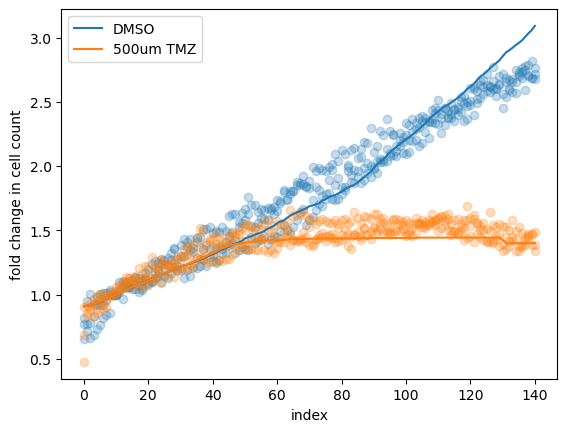

In [5]:
pdf = pd.read_csv("../data/inference/fitted_exp33PD.csv")
x = np.arange(0,141)
plt.figure()
for name in ["02_DMSO alltime", "06_DMSO30 min removed", "10_DMSO 2h removal"]:
    plt.scatter(x, (df[name] / df[name][10]), alpha=0.25, color="C0")

for name in ["04_500um alltime", "08_500um 30 min removal", "12_500um 2h removal"]:
    plt.scatter(x, (df[name] / df[name][10]), alpha=0.25, color="C1")

plt.plot(pdf.index, pdf.DMSO / pdf.DMSO[10], label="DMSO")
plt.plot(pdf.index, pdf["500um"] / pdf["500um"][10], label="500um TMZ")
plt.legend()
plt.xlabel("index")
plt.ylabel("fold change in cell count")